In [13]:
import json
from unskript import nbparams
from unskript.fwk.workflow import Task, Workflow
from unskript.secrets import ENV_MODE, ENV_MODE_LOCAL

env = {"ENV_MODE": "ENV_MODE_LOCAL"}
secret_store_cfg = {"SECRET_STORE_TYPE": "SECRET_STORE_TYPE_LOCAL"}

paramDict = {"cluster": "doug-billing-3", "database": "dev", "region": "us-west-2", "secret_name": "awsuser-doug-redshift"}
unSkriptOutputParamDict = {}
paramDict.update(env)
paramDict.update(secret_store_cfg)

paramDict = {"cluster": "doug-billing-3", "database": "dev", "region": "us-west-2", "secret_name": "awsuser-doug-redshift"}
unSkriptOutputParamDict = {}
paramsJson = json.dumps(paramDict)
nbParamsObj = nbparams.NBParams(paramsJson)
cluster = nbParamsObj.get('cluster')
database = nbParamsObj.get('database')
region = nbParamsObj.get('region')
secret_name = nbParamsObj.get('secret_name')
w = Workflow(env, secret_store_cfg, None, global_vars=globals())

<h2 id="Introduction">Introduction<a class="jp-InternalAnchorLink" href="#Introduction" target="_self">&para;</a></h2>
<p>This RunBook takes data from your AWS Cost and Usage Report, and generates a chart of daily usage for the month for each AWS service.</p>
<p>It can also be configured to send alerts to slack if a day-over-day change in cost is over the defined threshold.</p>
<p>Read more in our blog posts:</p>
<p><a href="https://unskript.com/keeping-your-cloud-costs-in-check-automated-aws-cost-charts-and-alerting/" target="_blank" rel="noopener">https://unskript.com/keeping-your-cloud-costs-in-check-automated-aws-cost-charts-and-alerting/</a></p>
<p><a href="https://unskript.com/cloud-costs-charting-daily-ec2-usage-and-cost/" target="_blank" rel="noopener">https://unskript.com/cloud-costs-charting-daily-ec2-usage-and-cost/</a></p>
<h2 id="Prerequisites">Prerequisites<a class="jp-InternalAnchorLink" href="#Prerequisites" target="_self">&para;</a></h2>
<p>This RunBook requires a Cost and Usage report in RedShift (here's a link to the <a href="https://docs.aws.amazon.com/cur/latest/userguide/cur-create.html">AWS docs</a>).</p>
<p>To Update the Redshift table daily - take a look at the Update Redshift database from S3 RunBook.&nbsp; This will ensure that the data in the Redshift table is up to date.</p>
<h2 id="Steps">Steps<a class="jp-InternalAnchorLink" href="#Steps" target="_self">&para;</a></h2>
<ol>
<li>Get the ARN of the AWS Secret that can access your RedShift cluster.</li>
<li>Create the SQL Query.&nbsp; This query is built to get the sum of daily cost for each service in AWS.&nbsp; It automatically creates the tablename to match the month/year.</li>
<li>RedShift Query - Kicks off the Query.&nbsp;&nbsp;</li>
<li>RedShiftQuery Details - This tells us the status of the query.&nbsp; We are looking for the status to be equal to "finished."&nbsp; TODO- add polling to check for this automatically.</li>
<li>Get RedShift Result: Once the query has been completed - this Action pulls the data from Redshift</li>
<li>Chart the data: The data is pulledinto a dataframe, and several charts are made - for the month, and the last 7 days.</li>
<li>Bulid Alert - takes the last 2 days and compares the $$ spend.&nbsp; If the change is upwards, and it exceeds the threshold defined - run the last Action</li>
<li>Post image to Slack: If the alert is tripped - we'll send an alert to Slack with the chart from the last 7 days.&nbsp; Note: It also automatically sends every Monday as well.</li>
</ol>
<p>&nbsp;</p>

In [14]:
##
##  Copyright (c) 2023 unSkript, Inc
##  All rights reserved.
##

from __future__ import annotations

from typing import Optional

from pydantic import BaseModel, Field


from beartype import beartype
@beartype
def aws_get_secrets_manager_secretARN_printer(output):
    if output is None:
        return
    pprint.pprint({"secret": output})


@beartype
@beartype
@beartype
def aws_get_secrets_manager_secretARN(handle, region: str, secret_name:str) -> str:


    # Create a Secrets Manager client

    client = handle.client(
        service_name='secretsmanager',
        region_name=region
    )


    get_secret_value_response = client.get_secret_value(
        SecretId=secret_name
    )

    #print(get_secret_value_response)
    # Decrypts secret using the associated KMS key.
    secretArn = get_secret_value_response['ARN']
    return secretArn




task = Task(Workflow())

task.configure(inputParamsJson='''{
    "region": "region",
    "secret_name": "secret_name"
    }''')
task.configure(outputName="secretArn")

task.configure(printOutput=True)
(err, hdl, args) = task.validate(vars=vars())
if err is None:
    task.execute(aws_get_secrets_manager_secretARN, lego_printer=aws_get_secrets_manager_secretARN_printer, hdl=hdl, args=args)

{'secret': 'arn:aws:secretsmanager:us-west-2:100498623390:secret:awsuser-doug-redshift-KvL4U1'}


In [15]:
import datetime

today = datetime.datetime.now()

yearmonth = today.strftime('%Y%m')
tableName = 'awsbilling'+ yearmonth
todayDay = int(today.strftime('%d'))
yesterDay = 0
if todayDay >1:
    yesterDay = todayDay - 1

sqlQuery = f"select lineitem_productcode, date_part(day, cast(lineitem_usagestartdate as date)) as day, SUM((lineitem_unblendedcost)::numeric(37,4)) as cost from {tableName} group by lineitem_productcode, day order by cost desc;"

print(sqlQuery)





select lineitem_productcode, date_part(day, cast(lineitem_usagestartdate as date)) as day, SUM((lineitem_unblendedcost)::numeric(37,4)) as cost from awsbilling202304 group by lineitem_productcode, day order by cost desc;


In [16]:
##
##  Copyright (c) 2021 unSkript, Inc
##  All rights reserved.
##


from __future__ import annotations
from pydantic import BaseModel, Field
from typing import List, Dict
from unskript.connectors.aws import aws_get_paginator
import pprint
from beartype import beartype
@beartype
def aws_create_redshift_query(handle, region: str,cluster:str, database:str, secretArn: str, query:str) -> str:

    # Input param validation.
    #major change
    client = handle.client('redshift-data', region_name=region)
    # define your query
    query = query
    # execute the query
    response = client.execute_statement(
        ClusterIdentifier=cluster,
        Database=database,
        SecretArn=secretArn,
        Sql=query
    )
    resultId = response['Id']
    print(response)
    print("resultId",resultId)


    return resultId

#make a change


def unskript_default_printer(output):
    if isinstance(output, (list, tuple)):
        for item in output:
            print(f'item: {item}')
    elif isinstance(output, dict):
        for item in output.items():
            print(f'item: {item}')
    else:
        print(f'Output for {task.name}')
        print(output)

task = Task(Workflow())

task.configure(inputParamsJson='''{
    "cluster": "cluster",
    "database": "database",
    "query": "sqlQuery",
    "region": "region",
    "secretArn": "secretArn"
    }''')
task.configure(outputName="queryId")
task.configure(printOutput=True)
(err, hdl, args) = task.validate(vars=vars())
if err is None:
    task.execute(aws_create_redshift_query, lego_printer=unskript_default_printer, hdl=hdl, args=args)

{'ClusterIdentifier': 'doug-billing-3', 'CreatedAt': datetime.datetime(2023, 4, 7, 16, 27, 49, 803000, tzinfo=tzlocal()), 'Database': 'dev', 'Id': 'f88c7ba0-3d55-417c-9389-e7e64ea2f3df', 'SecretArn': 'arn:aws:secretsmanager:us-west-2:100498623390:secret:awsuser-doug-redshift-KvL4U1', 'ResponseMetadata': {'RequestId': 'f88c7ba0-3d55-417c-9389-e7e64ea2f3df', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'f88c7ba0-3d55-417c-9389-e7e64ea2f3df', 'content-type': 'application/x-amz-json-1.1', 'content-length': '224', 'date': 'Fri, 07 Apr 2023 16:27:49 GMT'}, 'RetryAttempts': 0}}
resultId f88c7ba0-3d55-417c-9389-e7e64ea2f3df
Output for aws_create_redshift_query
f88c7ba0-3d55-417c-9389-e7e64ea2f3df


In [17]:
from __future__ import annotations
##
##  Copyright (c) 2023 unSkript, Inc
##  All rights reserved.
##
from pydantic import BaseModel, Field
from typing import List, Dict
from unskript.connectors.aws import aws_get_paginator
import pprint
from beartype import beartype


from typing import Optional

from pydantic import BaseModel, Field


from beartype import beartype
@beartype
def aws_get_redshift_query_details(handle, region: str, queryId:str) -> Dict:

    client = handle.client('redshift-data', region_name=region)
    response = client.describe_statement(
    Id=queryId
    )
    resultReady = response['HasResultSet']
    queryTimeNs = response['Duration']
    ResultRows = response['ResultRows']
    details = {"Status": response['Status'],
                "resultReady": resultReady, 
               "queryTimeNs":queryTimeNs,
               "ResultRows":ResultRows
              }

    #return resultReady
    return details




def unskript_default_printer(output):

    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(output)

task = Task(Workflow())

task.configure(inputParamsJson='''{
    "queryId": "queryId",
    "region": "region"
    }''')
task.configure(printOutput=True)
(err, hdl, args) = task.validate(vars=vars())
if err is None:
    task.execute(aws_get_redshift_query_details, lego_printer=unskript_default_printer, hdl=hdl, args=args)

{   'ResultRows': 120,
    'Status': 'FINISHED',
    'queryTimeNs': 94011802,
    'resultReady': True}


In [18]:
from __future__ import annotations
##
##  Copyright (c) 2023 unSkript, Inc
##  All rights reserved.
##
from pydantic import BaseModel, Field
from typing import List, Dict
from unskript.connectors.aws import aws_get_paginator
import pprint
from beartype import beartype
import time


from beartype import beartype
@beartype
def aws_get_redshift_result(handle, region:str, resultId: str) -> List:

    time.sleep(10)
    client = handle.client('redshift-data', region_name=region)
    result = client.get_statement_result(
        Id=resultId
    )
    #result has the Dictionary, but it is not easily queried
    #get all the columns into an array
    columnNames = []
    for column in result['ColumnMetadata']:
        columnNames.append(column['label'])
    #print(columnNames)

    #now let's make the output into a dict
    listResult = []
    for record in result['Records']:

        for key, value in record[0].items():
            rowId = value
        entryCounter = 0
        entryDict = {}
        for entry in record:

            for key, value in entry.items():
                entryDict[columnNames[entryCounter]] = value
            entryCounter +=1
        #print("entryDict",entryDict)
        listResult.append(entryDict)

    #print(listResult)
    return listResult







task = Task(Workflow())

task.configure(inputParamsJson='''{
    "region": "region",
    "resultId": "queryId"
    }''')
task.configure(outputName="redshiftresult")

task.configure(printOutput=False)
(err, hdl, args) = task.validate(vars=vars())
if err is None:
    task.execute(aws_get_redshift_result, lego_printer=unskript_default_printer, hdl=hdl, args=args)

Task Executed


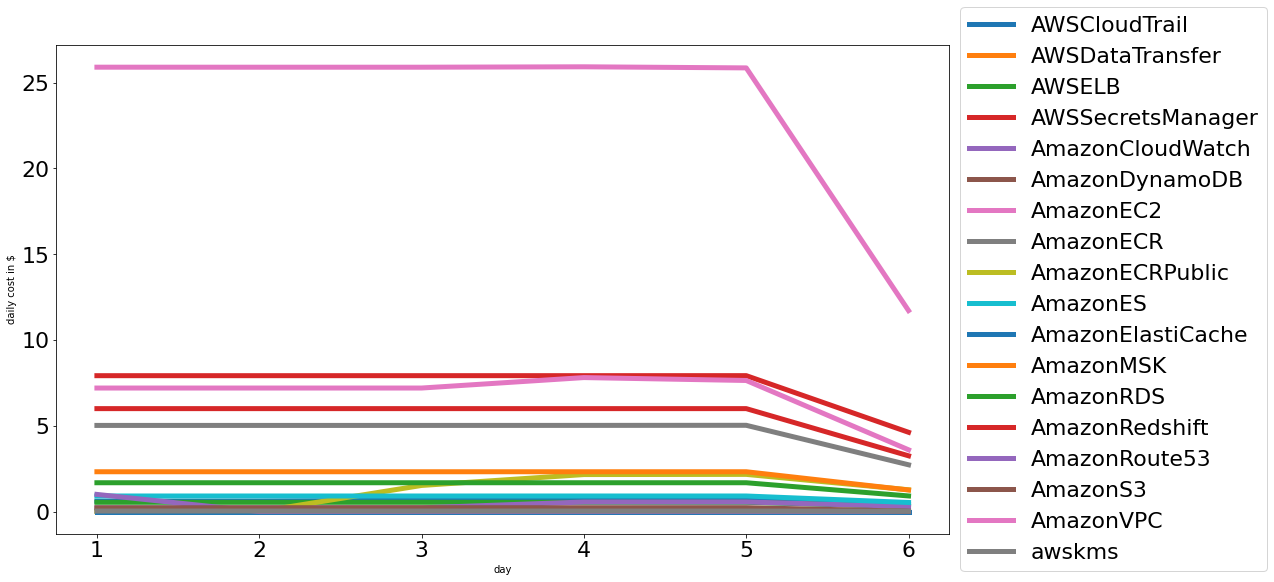

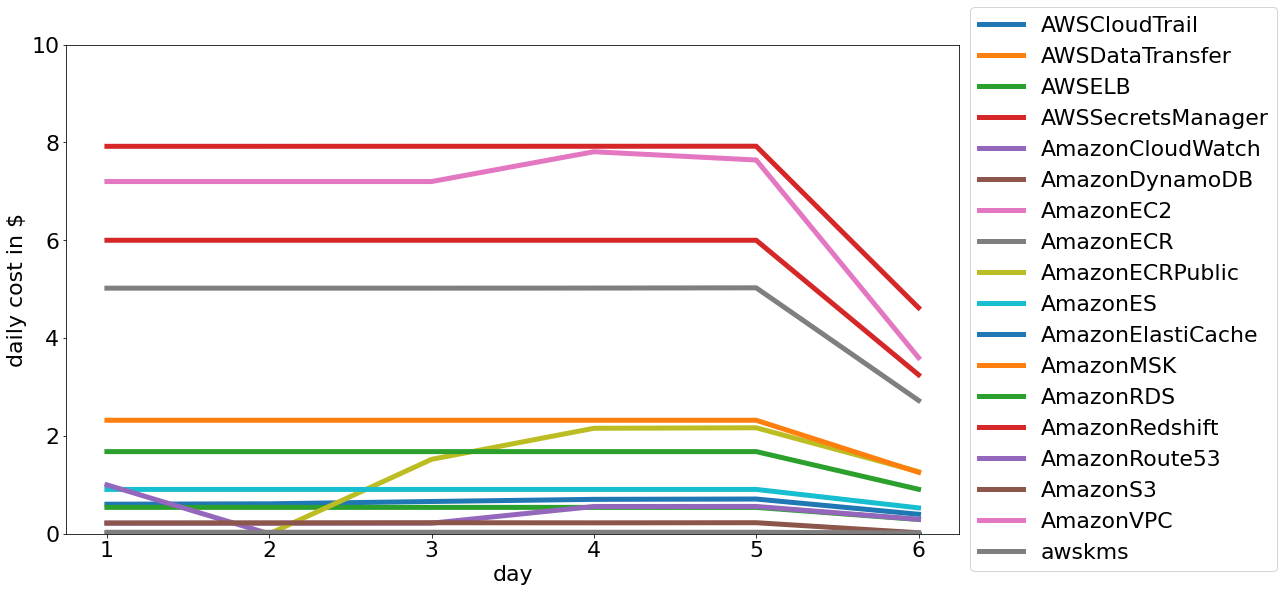

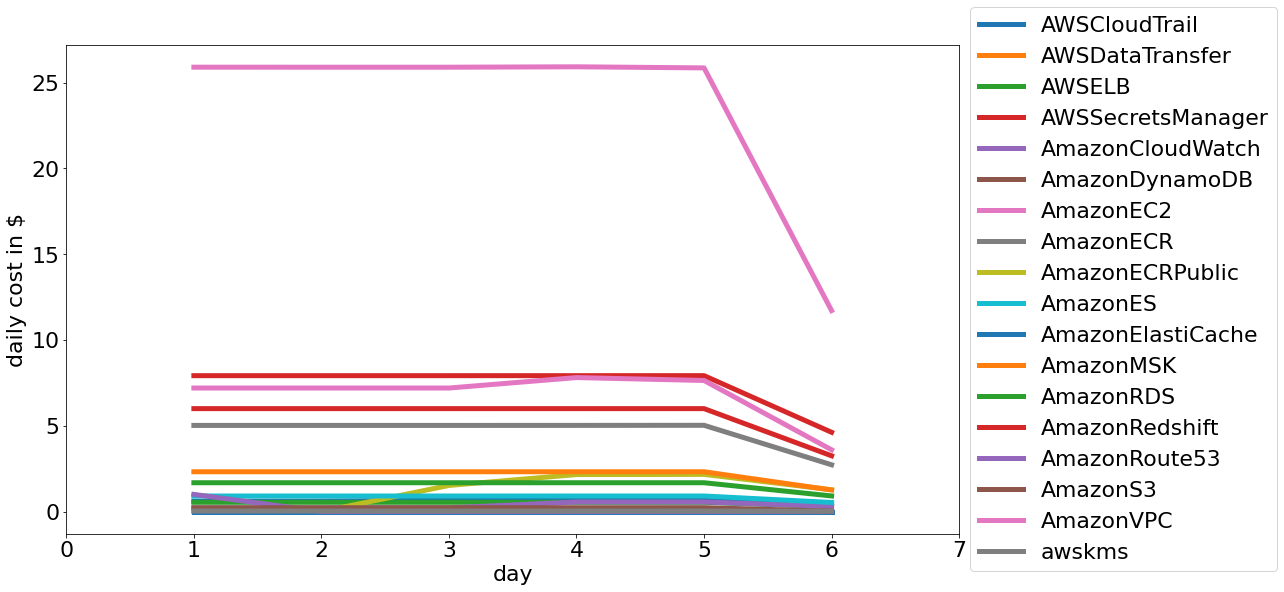

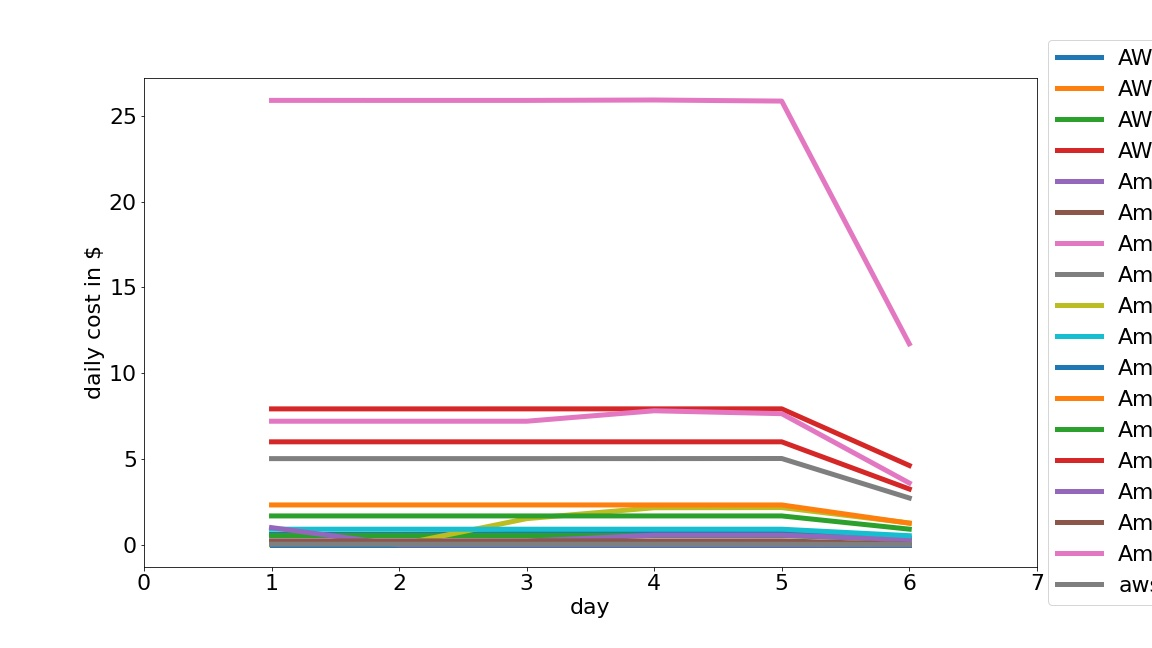

In [9]:
import matplotlib as mpl
mpl.use('agg')
from matplotlib.figure import Figure
import panel
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import io, base64, urllib
from PIL import Image

df = pd.DataFrame.from_dict(redshiftresult)
df['cost']=df['cost'].astype(float)
df['day']=df['day'].astype(int)

%matplotlib inline

font = {'size' : 22}
dfpivot = df.pivot(index='day', columns='lineitem_productcode', values='cost')
dfpivot.plot(linewidth=5,ylabel="daily cost in $", figsize=(16, 9) )

plt.rc('font', **font)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.show()

dfpivot.plot(linewidth=5,ylabel="daily cost in $", figsize=(16, 9) )
plt.ylim((0,10))
plt.rc('font', **font)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

dfpivot.plot(linewidth=5,ylabel="daily cost in $", figsize=(16, 9) )
plt.xlim((todayDay-7,todayDay))
plt.rc('font', **font)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig = plt.gcf()
plt.show()


fig.savefig('awsProducts7Day.jpg')
im  = Image.open('awsProducts7Day.jpg')
display(im)



In [19]:
from datetime import date 


today = todayDay -1
yesterday =yesterDay -1

print(today)
bigchange = {}
listChange = []
alert = False
alertText = ''
if yesterday >0:
    for instance in dfpivot.columns:
        todayCost = dfpivot.at[today, instance]
        yesterdayCost = dfpivot.at[yesterday, instance]

        delta =(todayCost-yesterdayCost)/yesterdayCost
        if abs(todayCost-yesterdayCost) >1: 
            if delta >.05:
                #print( instance, delta,dfpivot.at[today, instance], dfpivot.at[yesterday, instance])
                bigchange[instance] = {"delta":delta, "todayCost":todayCost,"yesterdayCost":yesterdayCost}
                listChange.append([instance, yesterdayCost, todayCost])
                alertText = '@here There has been a large change in AWS Costs'
                alert = True
            if date.today().weekday() == 0:
                alertText = 'Today is Monday, Here is the last week of AWS Costs'
                alert = True
    print(listChange)
    print("bigchange", bigchange)

6
[]
bigchange {}


In [20]:
##
# Copyright (c) 2021 unSkript, Inc
# All rights reserved.
##

import pprint

from pydantic import BaseModel, Field
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError

pp = pprint.PrettyPrinter(indent=2)

from beartype import beartype

from beartype import beartype
@beartype
def slack_post_image_printer(output):
    if output is not None:
        pprint.pprint(output)
    else:
        return


@beartype
@beartype
def slack_post_image(
        handle: WebClient,
        channel: str,
        comment: str,
        image: str) -> str:

    try:
        result = handle.files_upload(
            channels = channel,
            initial_comment=comment,
            file=image
    )
        return f"Successfuly Sent Message on Channel: #{channel}"

    except Exception as e:
        print("\n\n")
        pp.pprint(
            f"Failed sending message to slack channel {channel}, Error: {e.__str__()}")
        return f"Unable to send message on {channel}"


task = Task(Workflow())

task.configure(inputParamsJson='''{
    "channel": "\\"devrel_doug_test1\\"",
    "image": "'awsProducts7Day.jpg'",
    "comment": "alertText"
    }''')
task.configure(conditionsJson='''{
    "condition_enabled": true,
    "condition_cfg": "alert",
    "condition_result": true
    }''')
task.configure(printOutput=True)
(err, hdl, args) = task.validate(vars=vars())
if err is None:
    task.execute(slack_post_image, lego_printer=slack_post_image_printer, hdl=hdl, args=args)

Error in obtaining credential: 1 validation error for SlackSchema
bot_user_oauth_token
  field required (type=value_error.missing)
